# Process the input data

Use [spacepy](https://spacepy.github.io/quickstart.html#omni-module) to download the [Qin-Denton version](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006SW000296) of the [NASA OMNIWeb dataset](https://omniweb.gsfc.nasa.gov/ow.html) of solar wind properties.

These solar wind properties are ultimately measured by [spacecraft (WIND, ACE)](https://omniweb.gsfc.nasa.gov/html/ow_data.html#prior) orbiting the Lagrangian 1 point ~1.5 million km sunward of Earth.\
Note that the OMNIWeb dataset has [cleaned these source data up](https://omniweb.gsfc.nasa.gov/html/ow_data.html#data_clean), and has also advected (time-shifted) these data [from L1 to near-Earth space](https://omniweb.gsfc.nasa.gov/html/ow_data.html#time_shift).\
And the further post-processing done by the [Qin-Denton dataset has filled in datagaps](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2006SW000296).
As such, the data are NOT at L1. Nor do they correspond to the messy real-time data measurements (from ACE and DSCOVR) with datagaps, warts and all which an operational tool would ultimately need to use to truly warn of an impending Carrington event.

We'll use these data however in this Space Apps challenge, as:
* the advection to Earth is ignorable for our proof-of-principle - in principle we could be getting similar measurements at L1 - so we'll pretend they are at L1!
* using cleaned-up science-grade data is considerably easier than using messy real-time data (note that the [WIND dataset mentioned in the challenge resources](https://2022.spaceappschallenge.org/challenges/2022-challenges/carrington-event/resources) is not available in real-time)
* spacepy offers a very convenient way to download a long period of data at sufficiently high (hourly) cadence for our purposes

## Imports

In [1]:
# Builtins
import datetime as dt
import pathlib as pl
import sys

# 3rd party modules
import h5py
import pandas as pd

# Local packages
# Some of our team are on Windows - resolve ".." for them!
local_packages_dir = pl.Path("../src").resolve()
sys.path.append(str(local_packages_dir))
import downloaddata as dd

## Settings

In [2]:
datafile = pl.Path("~/.spacepy/data/omnidata.h5").expanduser().resolve()

## Download solar wind data from OMNI
Our local module downloads OMNI data using spacepy\
This takes a few minutes.\
This raises an ignorable error at end, due to CDF library not being installed.\
We've not done this as [installing the CDF library is painful](https://spacepy.github.io/dependencies.html#cdf-2-7) - we'll use other packages to read the downloaded data

In [3]:
if not datafile.exists():
    dd.download_data()

## Read solar wind data
Irritatingly, while our datafile nicely contains hourly solar wind values from ~1963 to present, it's quite painful to read:
* It is not in the [format expected by pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-hdf5)
* It doesn't play nicely with [xarray](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) either

So we've got to do some low-level hacking with h5py :(

Note also h5dump reveals there's not much/any metadata in this file (not shown) to help interpret contents (e.g. field long descriptions, units, ...). We can however refer to the [description of file contents in Qin et al, 2007](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006SW000296#swe208-sec-0010-title), and [json-formatted header metadata at the VIRBO source](https://rbsp-ect.newmexicoconsortium.org/data_pub/QinDenton/QDheader.txt).

In [4]:
# Add some metadata ourselves to some of the keys we may want to read
# Keys we're ignoring:
# 'ByIMF', 'Bz1', 'Bz2', 'Bz3', 'Bz4', 'Bz5', 'Bz6', 'BzIMF', 'DOY', 'G1', 'G2', 'G3', 'Qbits', 'RDT', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'akp3',
keys_to_read = {
    "Dst": {
        "description": "disturbance storm time index",
        "unit": "nT",
        "url": "https://en.wikipedia.org/wiki/Disturbance_storm_time_index",
    },
    "Kp": {
        "description": "planetary K index",
        "unit": "",
        "url": "https://en.wikipedia.org/wiki/K-index#The_Kp-index_and_estimated_Kp-index",
    },
    "Pdyn": {
        "description": "dynamic pressure",
        "unit": "nPa",
        "url": "https://en.wikipedia.org/wiki/Solar_wind#Pressure",
    },
    "UTC": {
        "description": "datetime (UTC)",
        "unit": "",
        "url": "",
    },
    "dens": {
        "description": "solar wind density",
        "unit": "cm-3",
        "url": "https://en.wikipedia.org/wiki/Solar_wind#Velocity_and_density",
    },
    "velo": {
        "description": "solar wind speed",
        "unit": "km/s",
        "url": "https://en.wikipedia.org/wiki/Solar_wind#Velocity_and_density",
    },
}

In [5]:
# Read our datafile
with h5py.File(datafile,"r") as fo:
    data = {key: fo[key][:] for key in keys_to_read.keys()}

# Convert the bytestring dates to strings
data["UTC"] = [dt.decode("utf8") for dt in data["UTC"]]

# Convert to a dataframe, and change date column to a date index
data = pd.DataFrame(data)
data.set_index(pd.DatetimeIndex(data['UTC']), inplace=True)
data = data.drop(columns=["UTC"])

## Initial look at data
Let's have a look at our data...

In [6]:
def look_at_data(data):
    """Get an overview of our data"""
    with pd.option_context('display.precision', 2):
        print(f"First and last rows of data:\n{data}\n")
        print(f"Summary statistics:\n{data.describe()}")

look_at_data(data)

First and last rows of data:
                     Dst    Kp  Pdyn   dens   velo
UTC                                               
1963-11-27 14:00:00   -3   0.7  1.71  10.50  285.0
1963-11-27 15:00:00   -3   0.3  1.95  12.00  285.0
1963-11-27 16:00:00   -1   0.3  1.95  12.00  285.0
1963-11-27 17:00:00   -1   0.3  1.95  12.00  285.0
1963-11-27 18:00:00   -3   1.0  2.30  13.70  290.0
...                  ...   ...   ...    ...    ...
2022-01-19 19:00:00  -20  99.0  0.00   2.67  513.6
2022-01-19 20:00:00  -20  99.0  0.00   2.67  513.6
2022-01-19 21:00:00  -17  99.0  0.00   2.67  513.6
2022-01-19 22:00:00  -15  99.0  0.00   2.67  513.6
2022-01-19 23:00:00  -14  99.0  0.00   2.67  513.6

[509722 rows x 5 columns]

Summary statistics:
             Dst         Kp       Pdyn       dens       velo
count  509722.00  509722.00  509722.00  509722.00  509722.00
mean      -14.14       2.11       2.36       6.93     436.60
std        22.05       1.94       1.71       4.97      98.92
min      -589.00

## Sanitising data
As-is, our data is at hourly cadence, and runs from 1963 to ~present, with some invalid Kp values (> 9) at the end.

We'll want to:
* Remove the most recent data with invalid Kp values
* Restrict the data to the period ~1995 onwards, where the OMNI dataset has fewer datagaps, so less will have been filled by the Qin-Denton method
  * See e.g. Fig 2 of [Lockwood et al, \[2018\]](https://doi.org/10.1029/2018SW001856)
  * Note discarding pre-1995 may exclude some coronal mass ejection signatures present in OMNIWeb, however the paper above shows there are many datagaps.
  * Furthermore good records of coronal mass ejections in in-situ solar wind data at L1 only start in ~1997, in the [Richardson and Cane ICME catalogue](https://izw1.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm)

In [7]:
# Sanitise our data:
# * remove dodgy Kp values at end
# * limit to more recent values
data = data[data["Kp"]<=9]
data = data.loc["1995":]
look_at_data(data)

First and last rows of data:
                     Dst   Kp  Pdyn   dens   velo
UTC                                              
1995-01-01 00:00:00   -2  1.0  2.87  16.30  315.0
1995-01-01 01:00:00    3  1.0  3.28  18.80  315.0
1995-01-01 02:00:00    6  1.0  3.46  19.30  320.0
1995-01-01 03:00:00    5  0.0  2.90  16.40  317.0
1995-01-01 04:00:00    3  0.0  2.51  14.50  313.0
...                  ...  ...   ...    ...    ...
2022-01-15 19:00:00  -31  4.0  0.00   2.67  513.6
2022-01-15 20:00:00  -29  4.0  0.00   2.67  513.6
2022-01-15 21:00:00  -35  4.7  0.00   2.67  513.6
2022-01-15 22:00:00  -42  4.7  0.00   2.67  513.6
2022-01-15 23:00:00  -42  4.7  0.00   2.67  513.6

[237048 rows x 5 columns]

Summary statistics:
             Dst         Kp       Pdyn       dens       velo
count  237048.00  237048.00  237048.00  237048.00  237048.00
mean      -11.80       1.78       2.00       6.29     426.26
std        19.41       1.34       1.62       4.96     100.74
min      -422.00       0.00  

## Examine a coronal mass ejection
Let's look at a coronal mass ejection from the [Richardson and Cane ICME* catalogue](https://izw1.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm)
* This has been subsampled to a nice [csv format](https://idoc.ias.u-psud.fr/sites/idoc/files/CME_catalog/html/ACE-ICMEs-list-dates-quality-nosheath-forweb.html) by [Regnault et al. \[2020\]](https://doi.org/10.1029/2020JA028150).
  * This could easily used to filter our data, in a similar way to selection below, so that the peak detection can concentrate on the CMEs
  * This paper is worth a read to look at the "average" CME profile across many CMEs - lots of variance visible in Fig 2 (see also Fig 4 for binned CMEs), but may nevertheless inform sensible machine learning follow-ons?
* Note there's also a useful [gist by Steve Morley](https://gist.github.com/drsteve/8c42ad03159fdcd415ba0bf575284f75) for parsing the  html in the original catalogue 

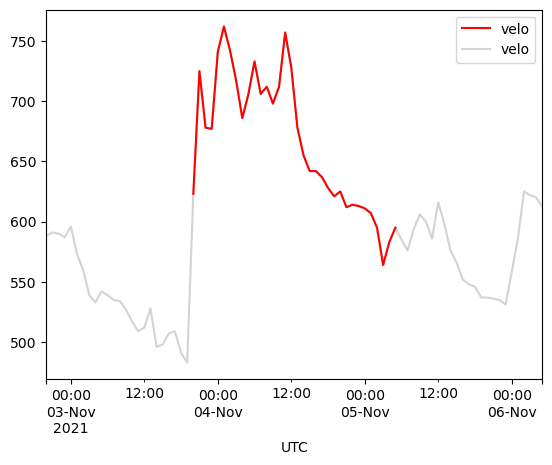

In [8]:
# Using dates for a CME in Richardson and Cane to filter our dataframe
cme_dates = {
    "disturbance": "2021-11-03T19:49", 
    "icme_start": "2021-11-04T07:00",
    "icme_end": "2021-11-05T05:00",
}
pad = {
    "start": dt.timedelta(days=-1),
    "end": dt.timedelta(days=1),
}
fromiso = dt.datetime.fromisoformat  # Abbreviate method for convenience
context_dates = {
    "start": fromiso(cme_dates["disturbance"]) + pad["start"],
    "end": fromiso(cme_dates["icme_end"]) + pad["end"],
}
cme = data.loc[cme_dates["disturbance"]:cme_dates["icme_end"]]
context = data.loc[context_dates["start"]:context_dates["end"]]
hax = cme.plot(y="velo", color="red", legend="ICME")
_ = context.plot(ax=hax, y="velo", color="lightgrey", zorder=0, legend="Context")